In [1]:
# Colab에 images.zip, GDUT_HWD.json, ssd160-mobilenet.h5 3개 파일 업로드

In [2]:
!git clone https://github.com/hukim1112/MLDL.git

Cloning into 'MLDL'...
remote: Enumerating objects: 238, done.
remote: Counting objects: 100% (238/238), done.
remote: Compressing objects: 100% (190/190), done.
remote: Total 238 (delta 68), reused 217 (delta 47), pack-reused 0
Receiving objects: 100% (238/238), 55.99 MiB | 40.34 MiB/s, done.
Resolving deltas: 100% (68/68), done.


In [3]:
import tensorflow as tf
import json, os, sys, time
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [4]:
sys.path.append("/content/MLDL/object_detection")

In [5]:
import anchor, losses, manage_checkpoint

In [6]:
config = {
    "exp_desc" : "perfection", #실험명
    "sub_desc" : "exp1", #하위실험명
    "image_dir" : "/content/images", #이미지경로
    "coco_api" : "/home/dan/prj/PythonAPI",
    "annotation_dir" : "/content/", #어노테이션 경로
    "label_set" : ["head","helmet"], # 분류할 오브젝트 집합
    "input_shape" : [160, 160, 3], #모델입력영상 크기
    "arch" : "ssd160",
    "backbone" : "mobilenet",
    "anchor_param" : {"ratios": [[2], [2, 3], [2, 3], [2]],
                           "scales": [0.1, 0.3, 0.6, 0.9, 1.05],
                           "fm_sizes": [10, 5, 3, 1],
                           "image_size": 160}, #anchor parameters
    "ckpt":
    {
        "save_type" : "best",
        "max_to_keep" : 10,
        "pretrained_type" : "init",
        "model_path" : None
    },
    "inference_mode" : "train", # train or mAP
    "train" :
    {
        "num_examples" : -1,
        "batch_size" : 16,
        "augmentation" : True,
        "random_crop_rate" : 0.3,
        "neg_ratio" : 3,
        "initial_lr" : 1e-3,
        "momentum" : 0.9,
        "weight_decay" : 5e-5,
        "num_epochs" : 300
    },
    "val":
    {
        "num_examples" : -1,
        "batch_size" : 64
    },
    "test":
    {
        "num_examples" : -1,
        "batch_size" : 1
    }

}
num_classes = len(config['label_set'])+1
log_dir = os.path.join('logs', 'perfection', 'exp1')
# if os.path.isdir(ckpt_dir):
#     raise ValueError("checkpoint directory exists. checkout your experiment name in configure file.")
# if os.path.isdir(log_dir):
#     raise ValueError("log directory exists. checkout your experiment name in configure file.")


# Dataset load

In [7]:
from pycocotools.coco import COCO
# test COCO api can load my json file
json = COCO("/content/GDUT_HWD.json")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [8]:
!ls images.zip
!unzip images.zip

images.zip
Archive:  images.zip
   creating: images/
  inflating: images/00170.jpg        
  inflating: images/02310.jpg        
  inflating: images/03141.jpg        
  inflating: images/01077.jpg        
  inflating: images/03327.jpg        
  inflating: images/02538.jpg        
  inflating: images/00290.jpg        
  inflating: images/02007.jpg        
  inflating: images/02587.jpg        
  inflating: images/01710.jpg        
  inflating: images/02081.jpg        
  inflating: images/03041.jpg        
  inflating: images/01447.jpg        
  inflating: images/02306.jpg        
  inflating: images/01312.jpg        
  inflating: images/02139.jpg        
  inflating: images/00571.jpg        
  inflating: images/01790.jpg        
  inflating: images/00984.jpg        
  inflating: images/01381.jpg        
  inflating: images/03386.jpg        
  inflating: images/02526.jpg        
  inflating: images/02877.jpg        
  inflating: images/00058.jpg        
  inflating: images/00574.jpg      

In [9]:
from coco import Dataset
ds_obj = Dataset(config, COCO)

In [10]:
batch_generator, train_length = ds_obj.load_data_generator('train', config)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [11]:
for i, (_, imgs, gt_confs, gt_locs) in enumerate(batch_generator.take(1)):
    print(imgs.shape, gt_confs.shape, gt_locs.shape)

(16, 160, 160, 3) (16, 608) (16, 608, 4)


# Model load

In [12]:
model = tf.keras.models.load_model("ssd160-mobilenet.h5")

In [13]:
model.layers[1].trainable = False
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 10, 10, 576)  616256      input_3[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 5, 5, 512)    569344      model[0][0]                      
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 3, 3, 512)    536576      sequential[0][0]                 
____________________________________________________________________________________________

In [14]:
model(imgs)

[<tf.Tensor: shape=(16, 608, 3), dtype=float32, numpy=
 array([[[-9.03265834e-01, -7.02643812e-01,  4.87498283e-01],
         [-1.30645037e-01, -2.65945196e-01,  8.85605931e-01],
         [-1.86990738e-01, -2.28509471e-01,  1.87198967e-01],
         ...,
         [ 9.21375431e-07, -1.16506690e-05, -7.44319505e-06],
         [-7.28237183e-06, -6.55176018e-06, -3.59577115e-07],
         [-1.91231834e-06, -1.55824716e-06,  8.50711240e-06]],
 
        [[-5.46004176e-01, -6.99375153e-01,  5.92752934e-01],
         [-4.59879607e-01,  5.13697267e-02,  8.48745644e-01],
         [-3.93778563e-01, -1.94883883e-01,  1.47151172e-01],
         ...,
         [ 3.00138737e-07, -1.09378025e-05, -8.77162893e-06],
         [-5.83923429e-06, -6.99636485e-06,  3.20636377e-06],
         [-2.61199875e-06, -3.17068407e-06,  7.39390862e-06]],
 
        [[-1.05812216e+00, -4.36095417e-01,  1.01679623e-01],
         [-1.57567501e-01, -2.50376940e-01,  7.70921707e-01],
         [-4.01371479e-01, -8.62025917e-02,

# Training loop

In [15]:
@tf.function
def train_step(imgs, gt_confs, gt_locs, ssd, criterion, optimizer, config):
    with tf.GradientTape() as tape:
        confs, locs = ssd(imgs)

        conf_loss, loc_loss = criterion(
            confs, locs, gt_confs, gt_locs)

        loss = conf_loss + loc_loss
        l2_loss = [tf.nn.l2_loss(t) for t in ssd.trainable_variables]
        l2_loss = config['train']['weight_decay'] * tf.math.reduce_sum(l2_loss)
        loss += l2_loss

    gradients = tape.gradient(loss, ssd.trainable_variables)
    optimizer.apply_gradients(zip(gradients, ssd.trainable_variables))

    return loss, conf_loss, loc_loss, l2_loss

criterion = losses.create_losses(config['train']['neg_ratio'], num_classes)

In [16]:
summary_writer = tf.summary.create_file_writer(log_dir)

t_loss = tf.metrics.Mean(name='train_loss')
t_conf_loss = tf.metrics.Mean(name='train_conf_loss')
t_loc_loss = tf.metrics.Mean(name='train_loc_loss')
# v_loss = tf.metrics.Mean(name='val_loss')
# v_conf_loss = tf.metrics.Mean(name='val_conf_loss')
# v_loc_loss = tf.metrics.Mean(name='val_loc_loss')

learning_rate = 1E-3
EPOCH = 50
START = 0
optimizer = tf.keras.optimizers.Adam(learning_rate)
for epoch in range(START+1, START+EPOCH+1):
    start = time.time()
    for i, (_, imgs, gt_confs, gt_locs) in enumerate(batch_generator):
        imgs = preprocess_input(imgs)
        loss, conf_loss, loc_loss, l2_loss = train_step(imgs, gt_confs, gt_locs, model, criterion, optimizer, config)
        t_loss(loss)
        t_conf_loss(conf_loss)
        t_loc_loss(loc_loss)
        
        print("Epoch {} iteration {} loss : {}".format(epoch, i, t_loss.result()))
    
    '''
    you can add the validation part
    
    for i, (_, imgs, gt_confs, gt_locs) in enumerate(val_generator):
        imgs = preprocess_input(imgs)
        val_confs, val_locs = model(imgs)
        val_conf_loss, val_loc_loss = criterion(val_confs, val_locs, gt_confs, gt_locs)
        v_loss(val_conf_loss+val_loc_loss)
        v_conf_loss(val_conf_loss)
        v_loc_loss(val_loc_loss)
    '''
    # Save checkpoint with a strategy.
    if epoch%10 == 0:
        model.save("{}.h5".format(epoch))

    with summary_writer.as_default():
        tf.summary.scalar('train_loss', t_loss.result(), step=epoch)
        tf.summary.scalar('train_conf_loss', t_conf_loss.result(), step=epoch)
        tf.summary.scalar('train_loc_loss', t_loc_loss.result(), step=epoch)
        #tf.summary.scalar('val_loss', v_loss.result(), step=epoch)
        #tf.summary.scalar('val_conf_loss', v_conf_loss.result(), step=epoch)
        #tf.summary.scalar('val_loc_loss', v_loc_loss.result(), step=epoch)
        tf.summary.scalar('learning_rate', learning_rate, step=epoch)
        
    t_loss.reset_states()
    t_conf_loss.reset_states()
    t_loc_loss.reset_states()
    #v_loss.reset_states()
    #v_conf_loss.reset_states()
    #v_loc_loss.reset_states()   

Epoch 1 iteration 0 loss : 12.561732292175293
Epoch 1 iteration 1 loss : 12.682439804077148
Epoch 1 iteration 2 loss : 11.339856147766113
Epoch 1 iteration 3 loss : 10.43607234954834
Epoch 1 iteration 4 loss : 9.789300918579102
Epoch 1 iteration 5 loss : 9.525923728942871
Epoch 1 iteration 6 loss : 9.224761009216309
Epoch 1 iteration 7 loss : 9.032912254333496
Epoch 1 iteration 8 loss : 9.026287078857422
Epoch 1 iteration 9 loss : 8.872501373291016
Epoch 2 iteration 0 loss : 7.284111499786377
Epoch 2 iteration 1 loss : 7.14794921875
Epoch 2 iteration 2 loss : 7.054727077484131
Epoch 2 iteration 3 loss : 6.773471355438232
Epoch 2 iteration 4 loss : 6.6233038902282715
Epoch 2 iteration 5 loss : 6.502135753631592
Epoch 2 iteration 6 loss : 6.363729953765869
Epoch 2 iteration 7 loss : 6.317321300506592
Epoch 2 iteration 8 loss : 6.136200904846191
Epoch 2 iteration 9 loss : 6.0889973640441895
Epoch 3 iteration 0 loss : 4.748188495635986
Epoch 3 iteration 1 loss : 4.675041675567627
Epoch 3 i

In [17]:
from post_process import predict

default_boxes = anchor.generate_default_boxes(config["anchor_param"])
confs, locs = model(imgs, training=False) #imgs.shape == (N,160,160,3)
batch_boxes, batch_classes, batch_scores = predict(confs, locs, default_boxes, num_classes, conf_thresh=0.5)
# 각 영상별 예측 bounding box(바운딩 박스)와 class(카테고리 번호), 그리고 scores(신뢰도)

In [30]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


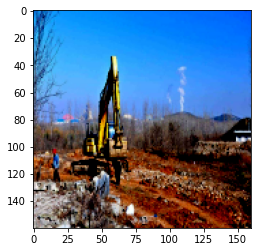

In [47]:
plt.imshow(imgs[1])

In [49]:
batch_boxes[1], batch_scores[1]

(array([[0.08507922, 0.63517827, 0.10597229, 0.6703791 ]], dtype=float32),
 array([0.6941917], dtype=float32))